# K2-3
Maybe TTVs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightkurve as lk
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [3]:
name = 'K2-3'

In [4]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))

In [5]:
obs = om.Observation.from_files(fnames, planet_letter='d')

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

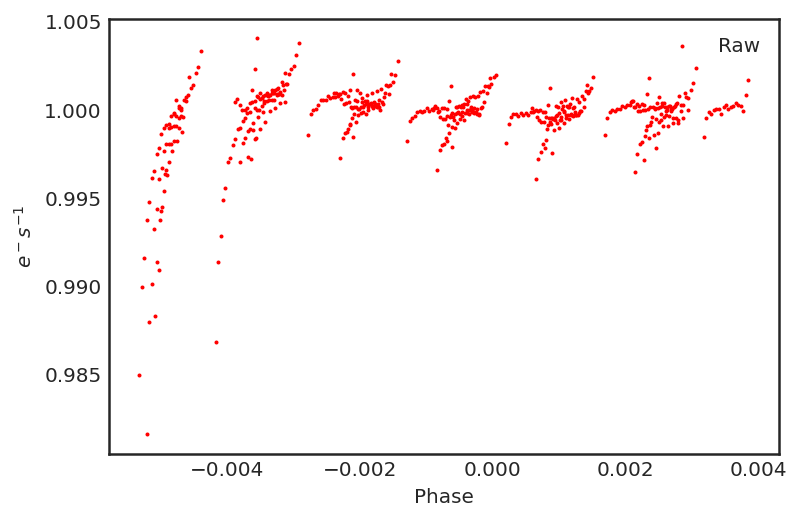

In [6]:
obs.plot()

In [7]:
clc = lk.search_lightcurve(name, author='K2SFF').download()
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s
clc = clc.flatten(51)
clc = clc[clc.flux.value > 0.97]
clc = clc.remove_outliers(sigma_upper=3, sigma_lower=1e2)

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

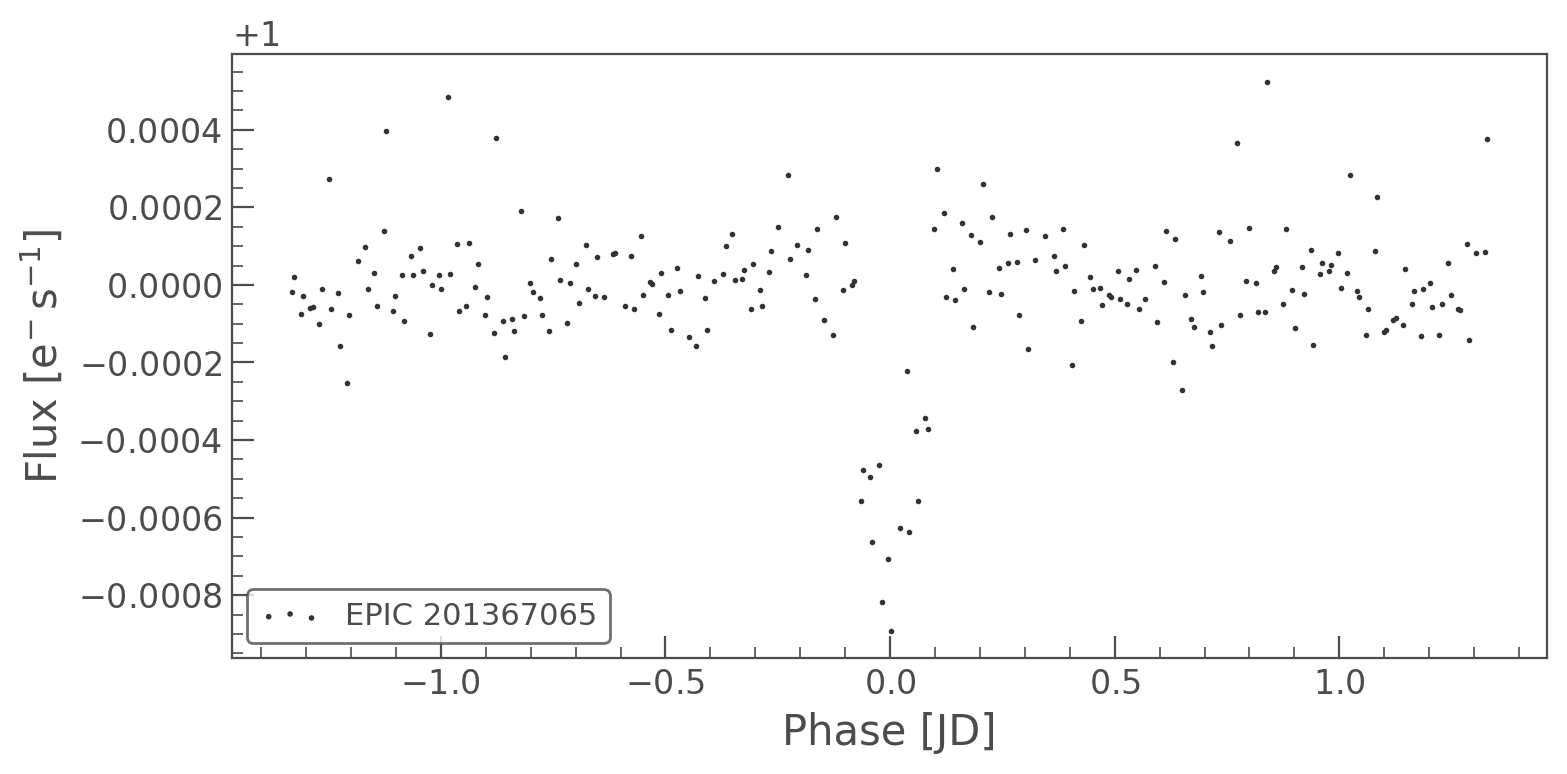

In [8]:
k = np.abs(((clc.time.value - (obs.t0 - 2454833 + obs.period/2))/obs.period) % 1 - 0.5) < 0.03
clc[k].fold(obs.period, obs.t0 - 2454833).scatter()

In [9]:
obs.fit_transit(x_suppl=clc.time.value[k] + 2454833,
                y_suppl=clc.flux.value[k],
                yerr_suppl=clc.flux_err.value[k],
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=True, fit_inc=False)

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

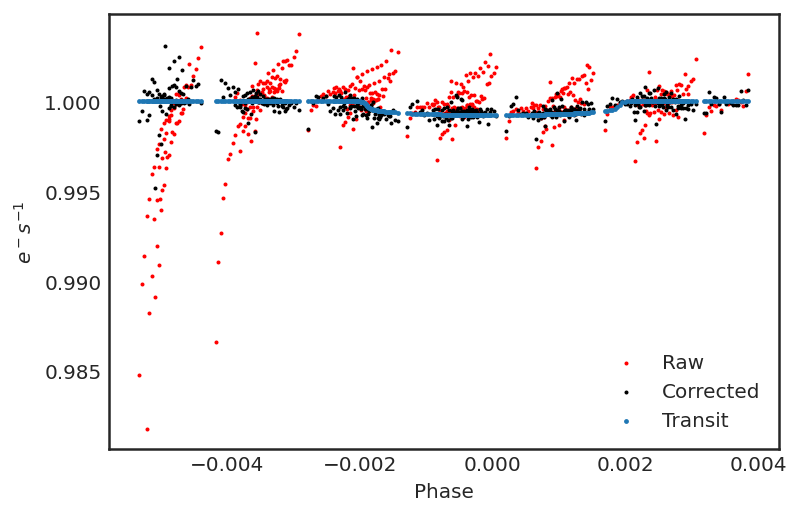

In [10]:
obs.plot()

In [11]:
obs.fit_model()

Fitting Transit/Eclipse Model: 100%|████████████| 10/10 [03:52<00:00, 23.28s/it]


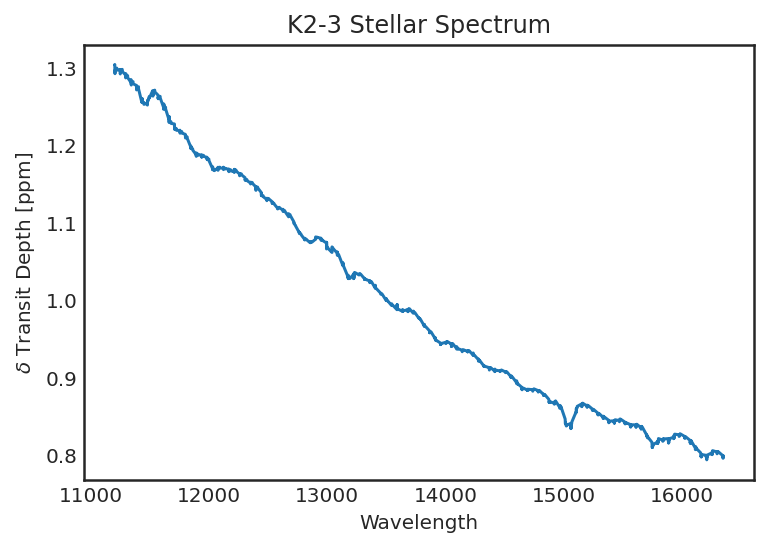

In [12]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

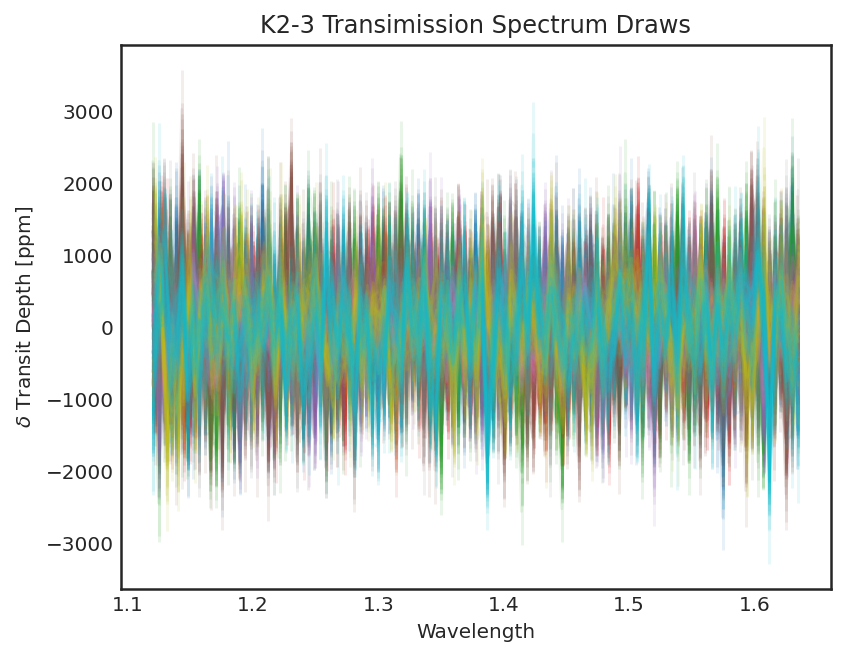

In [13]:
obs.plot_spectra()

[Text(0.5, 1.0, 'WASP-107 Transmission Spectrum')]

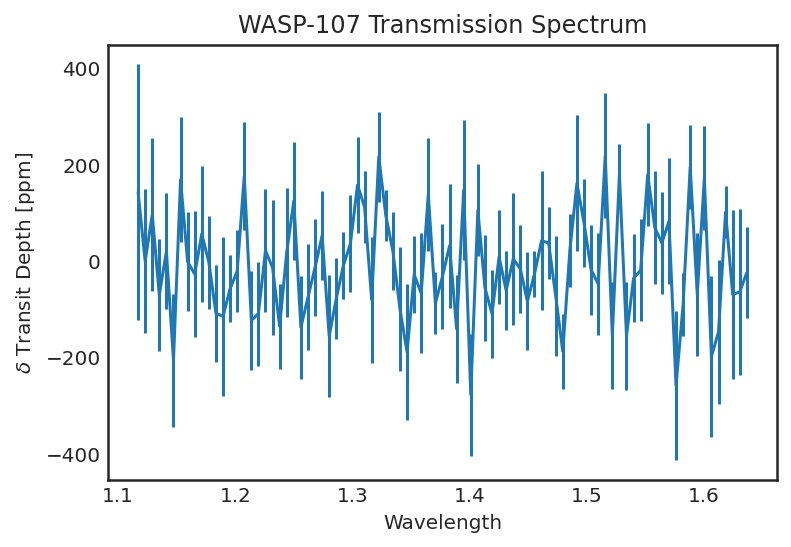

In [14]:
ax = om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 150)).plot()
ax.set(title='WASP-107 Transmission Spectrum')

In [15]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits')
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits')
except:
    pass

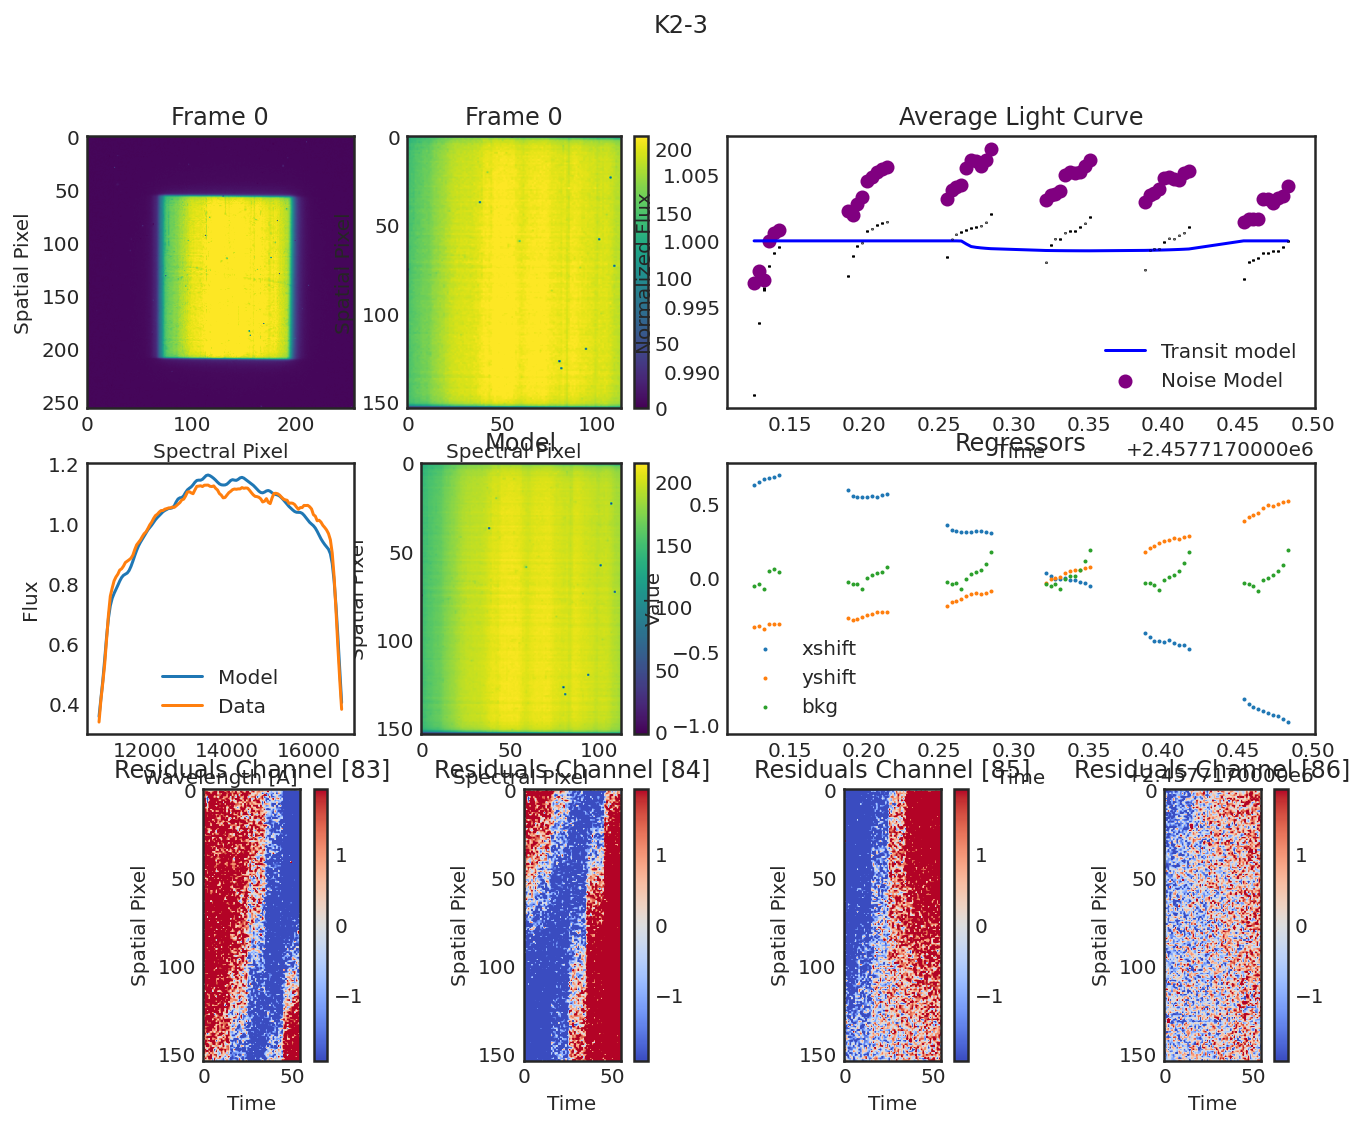

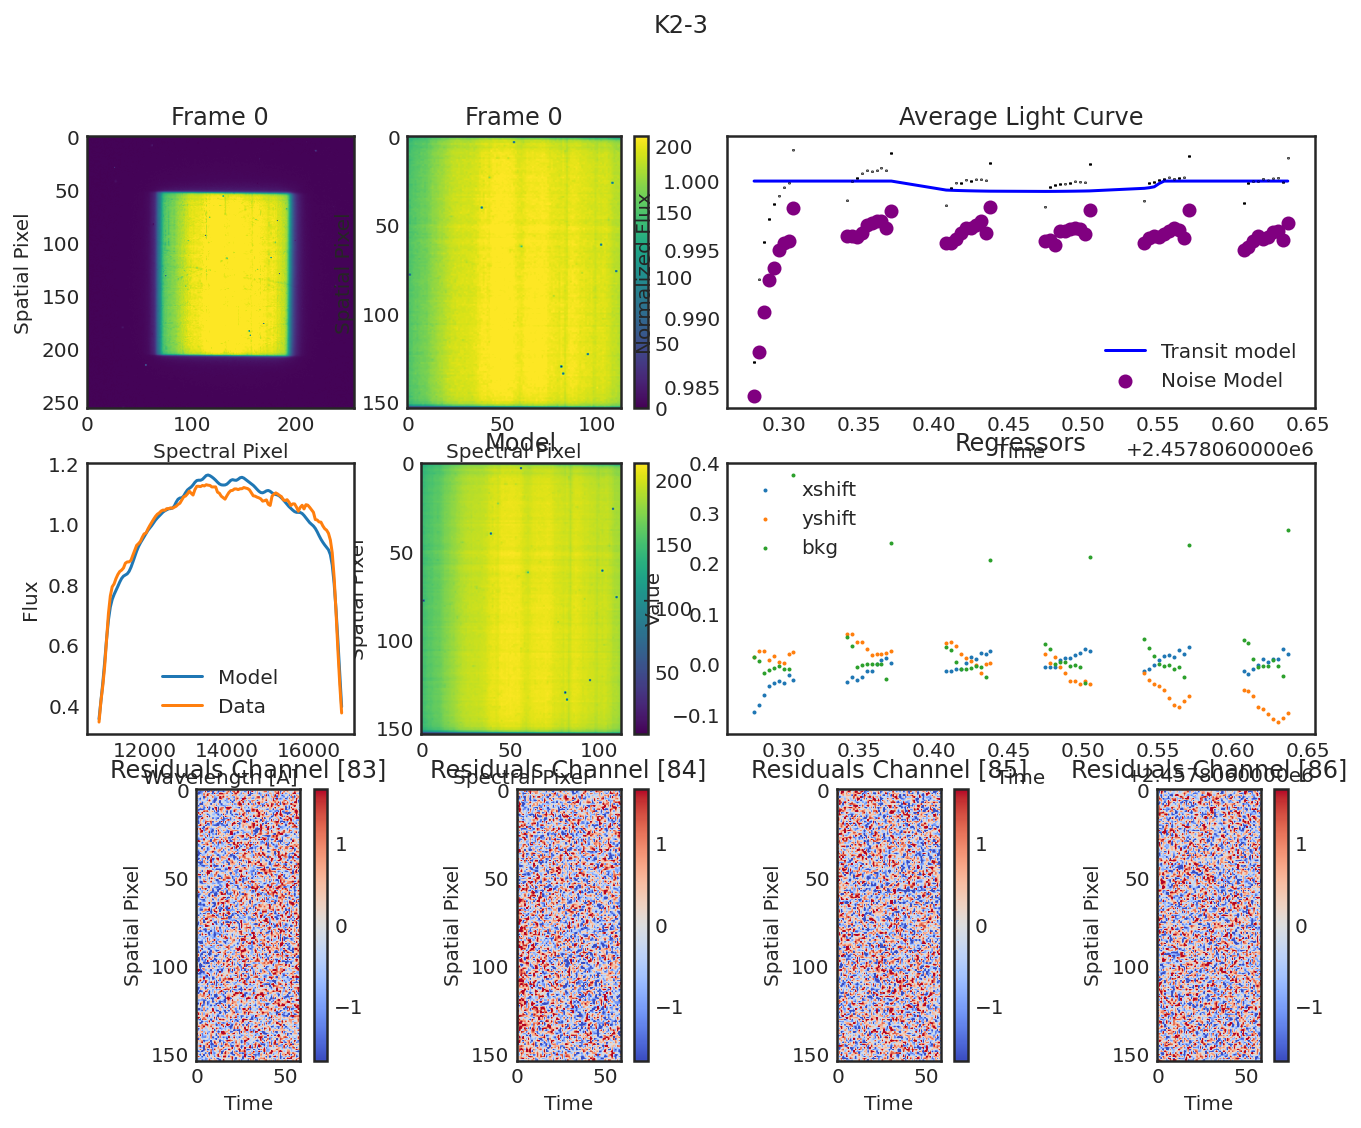

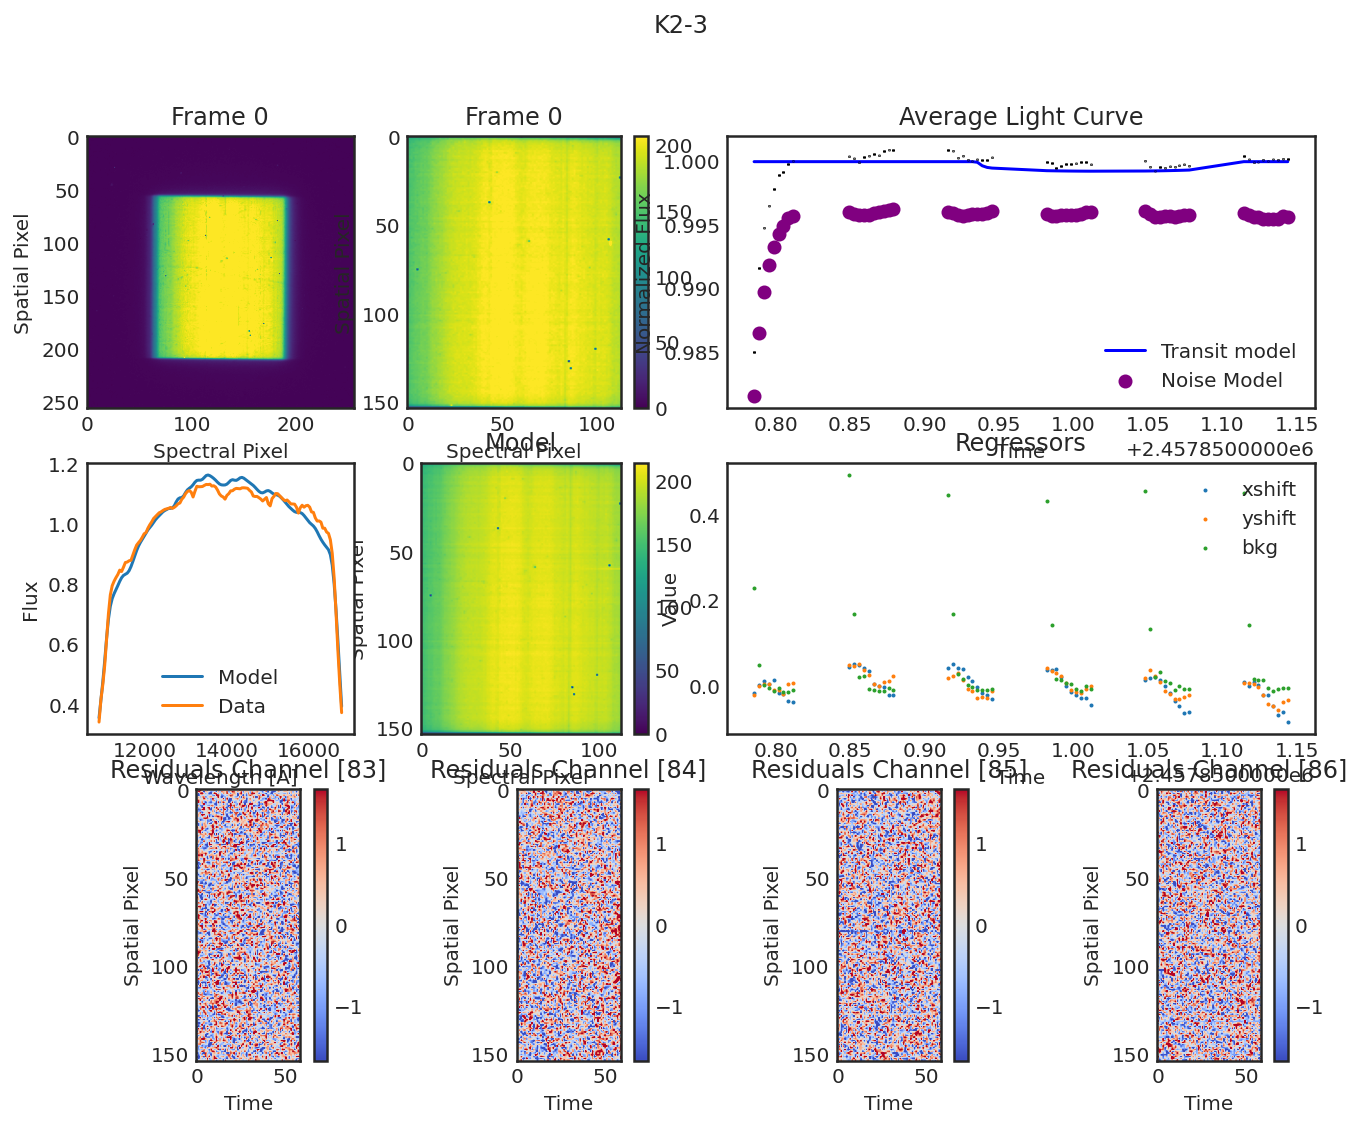

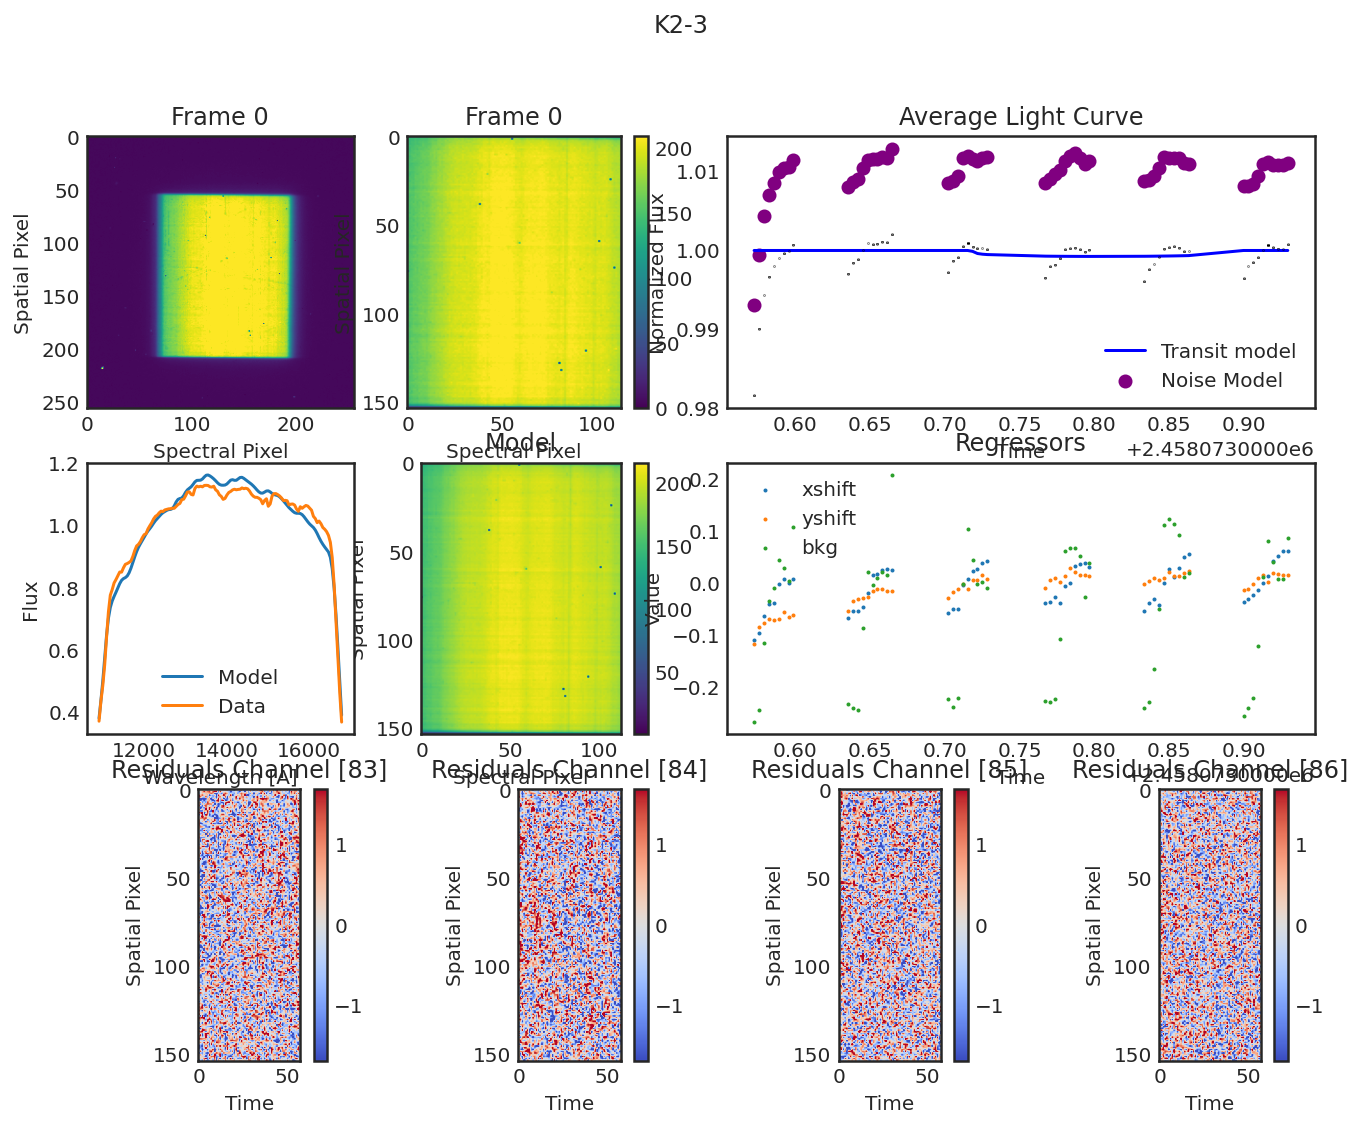

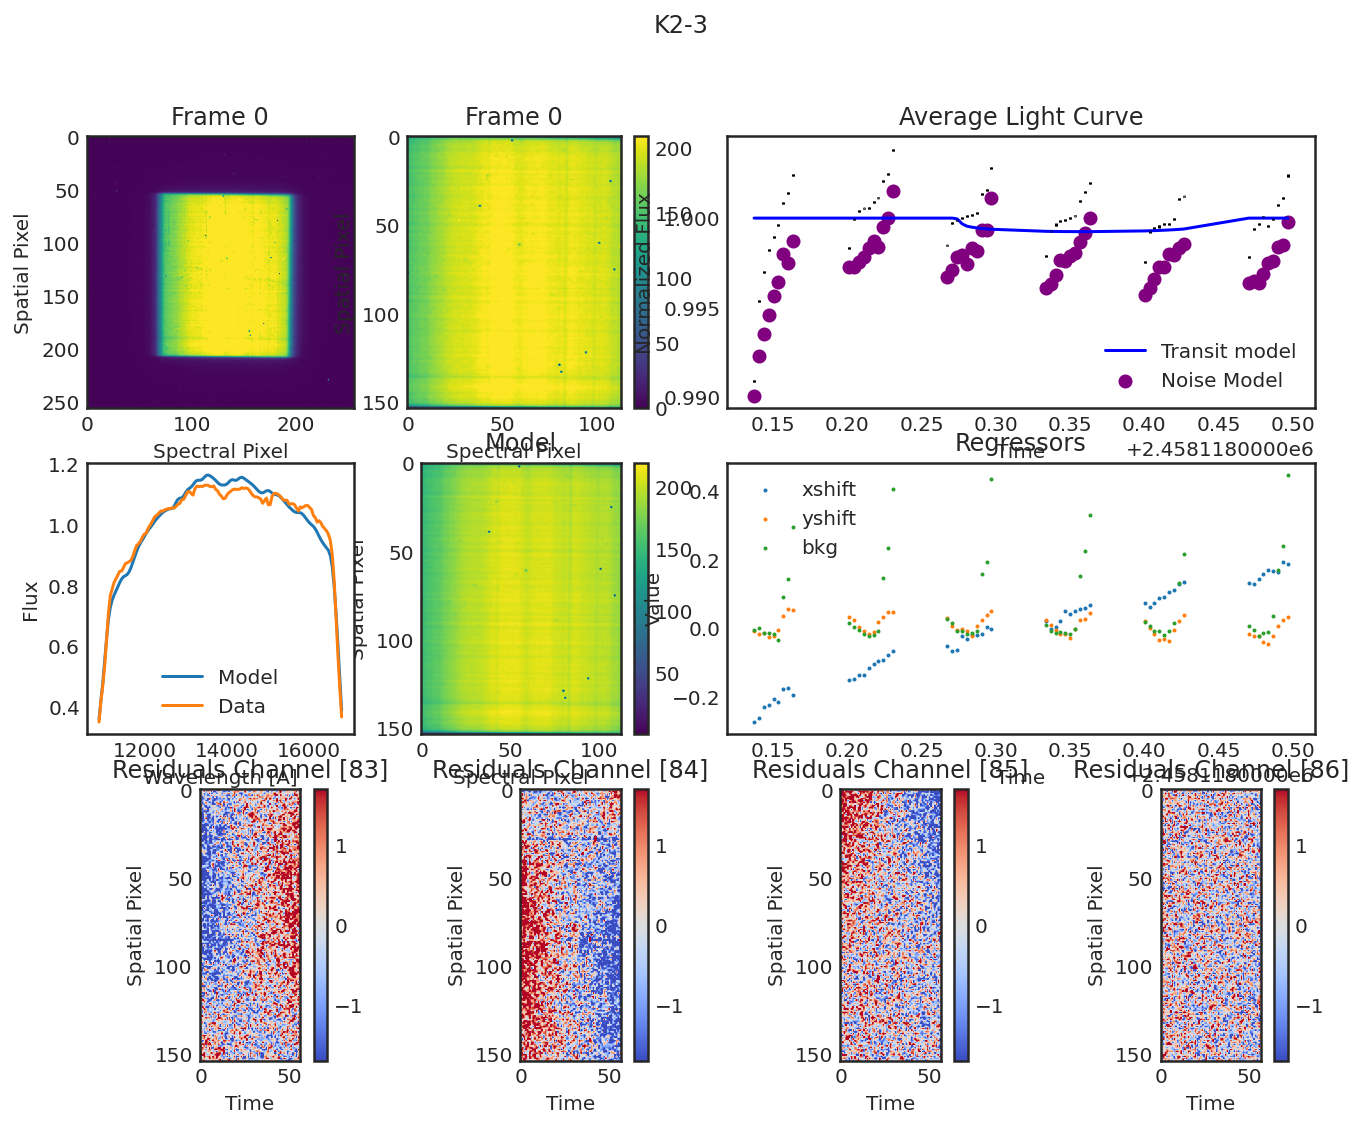

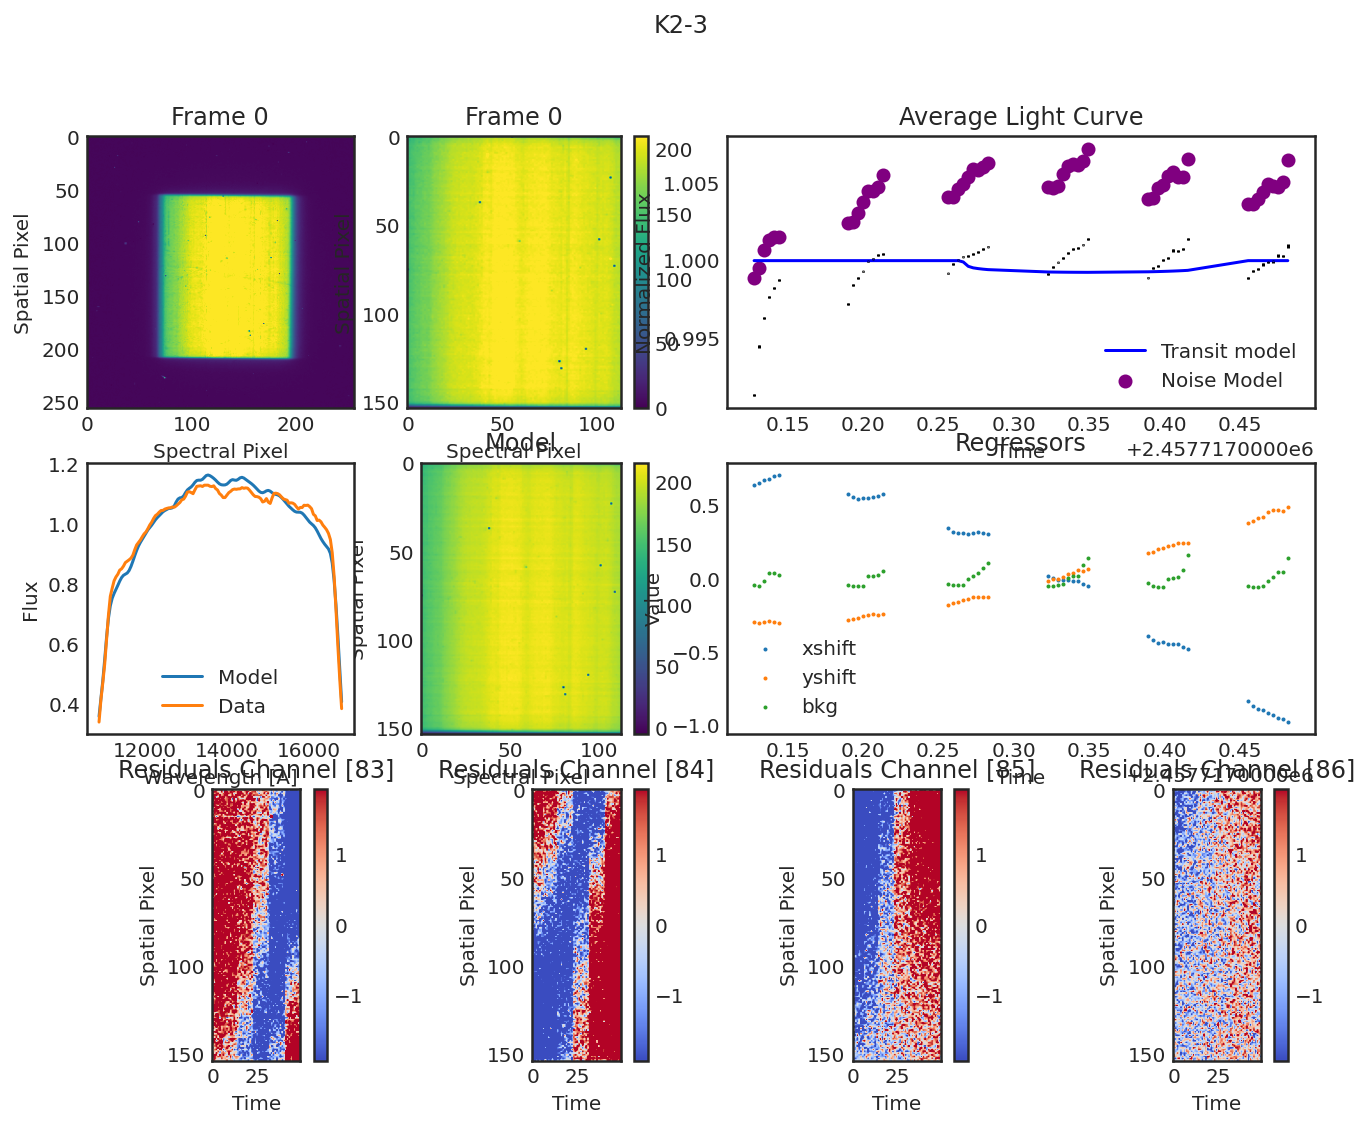

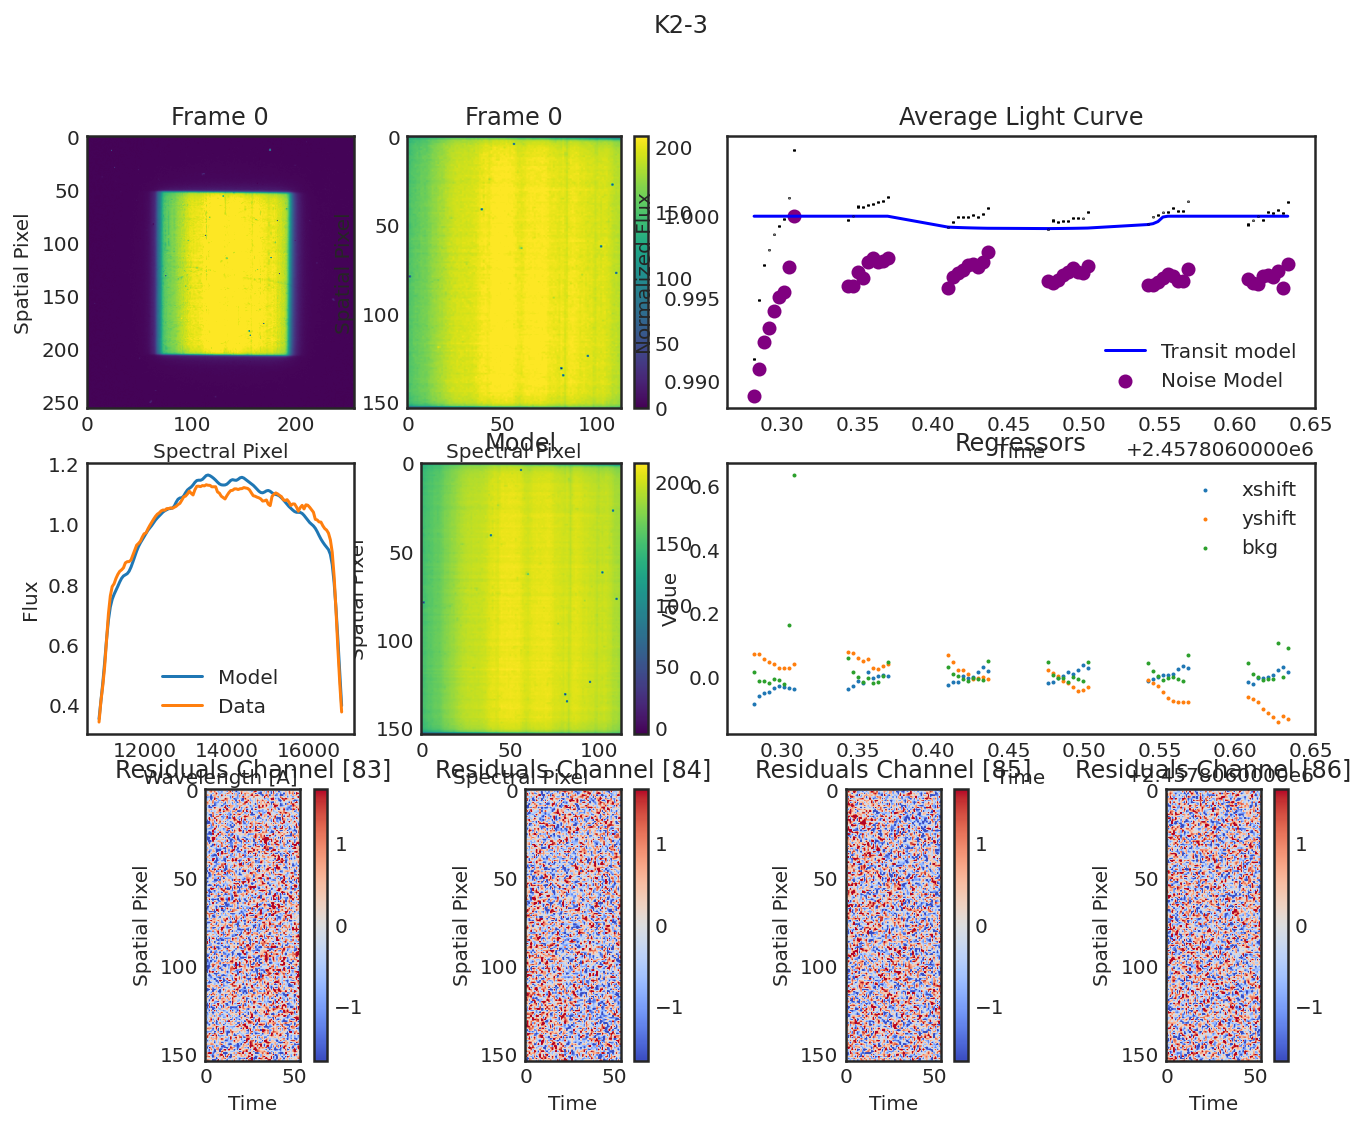

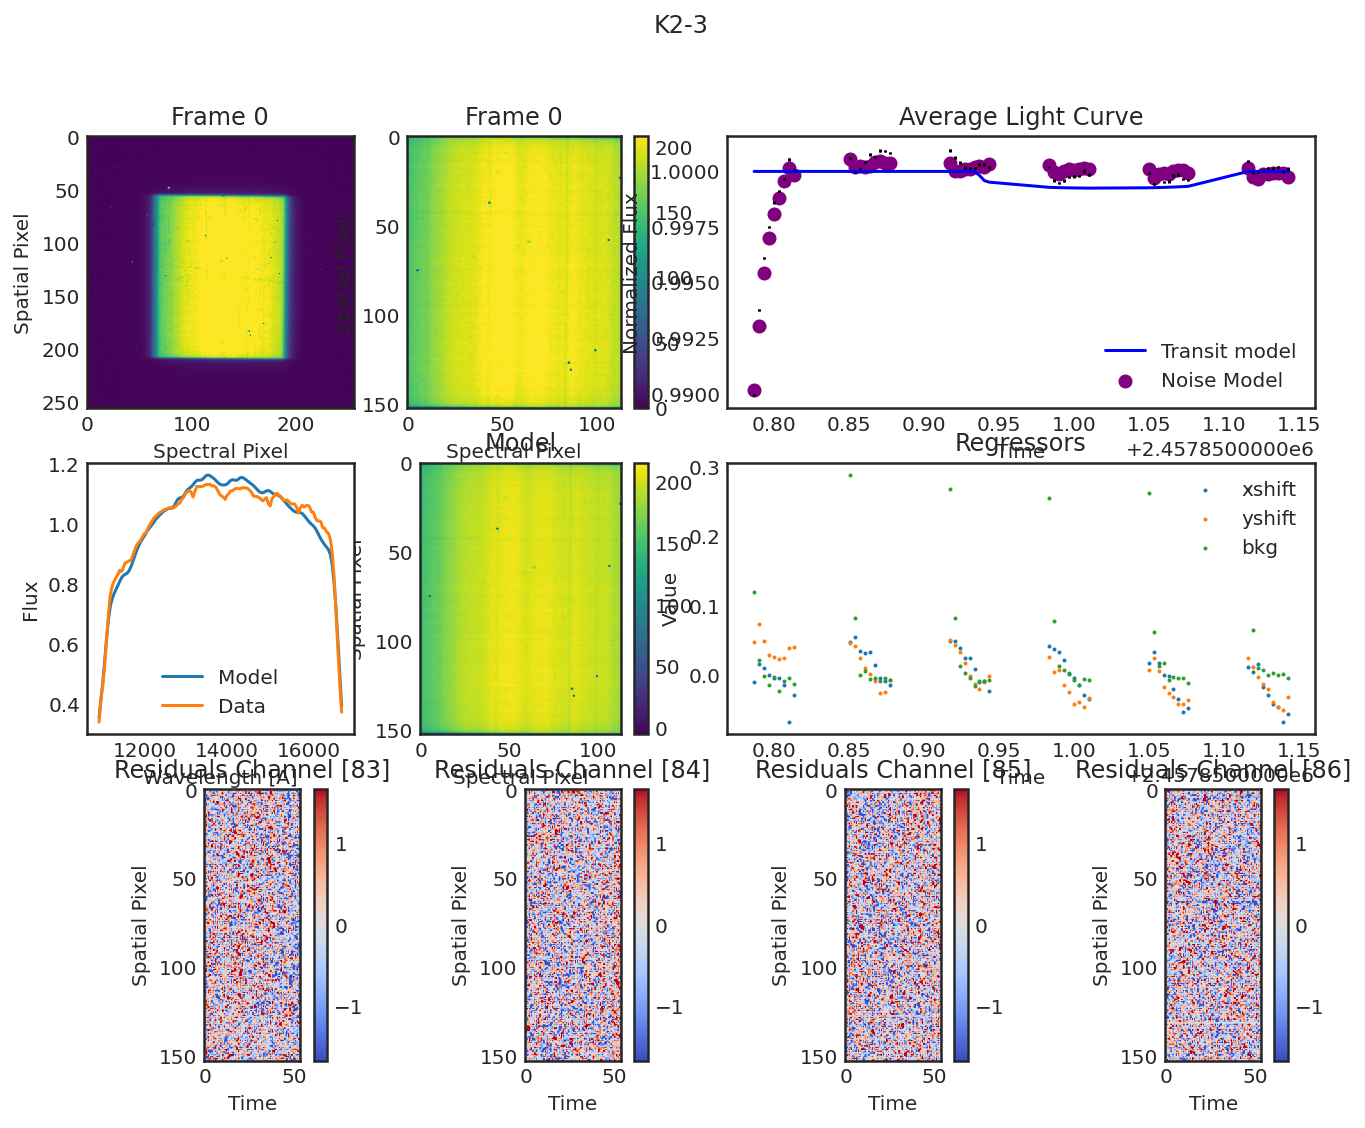

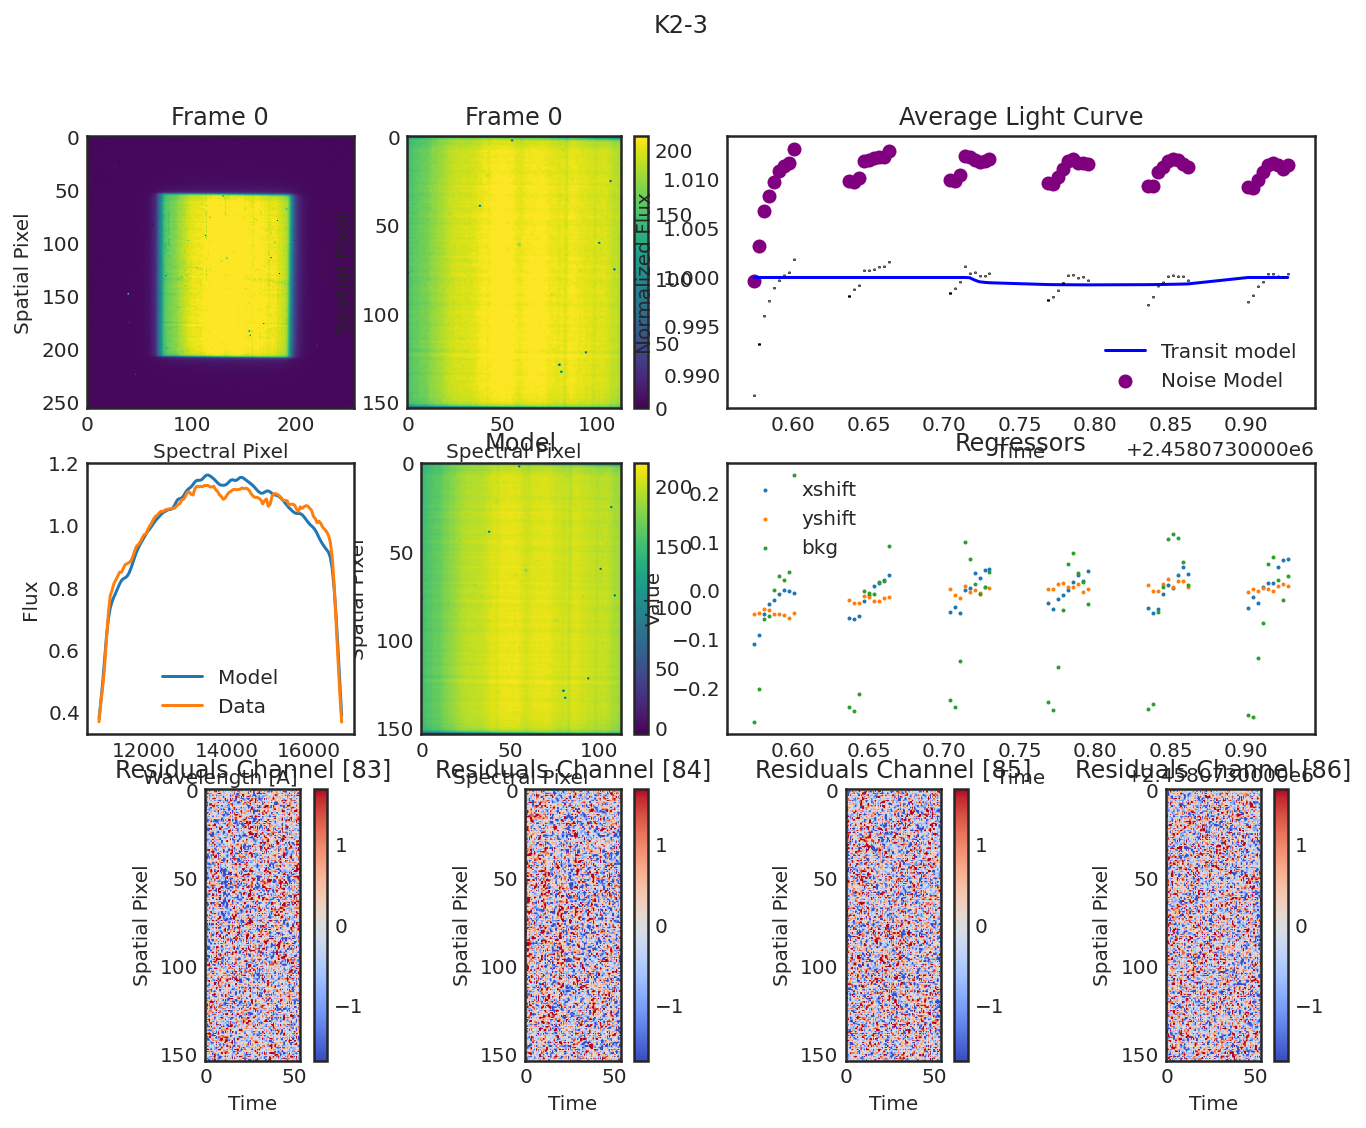

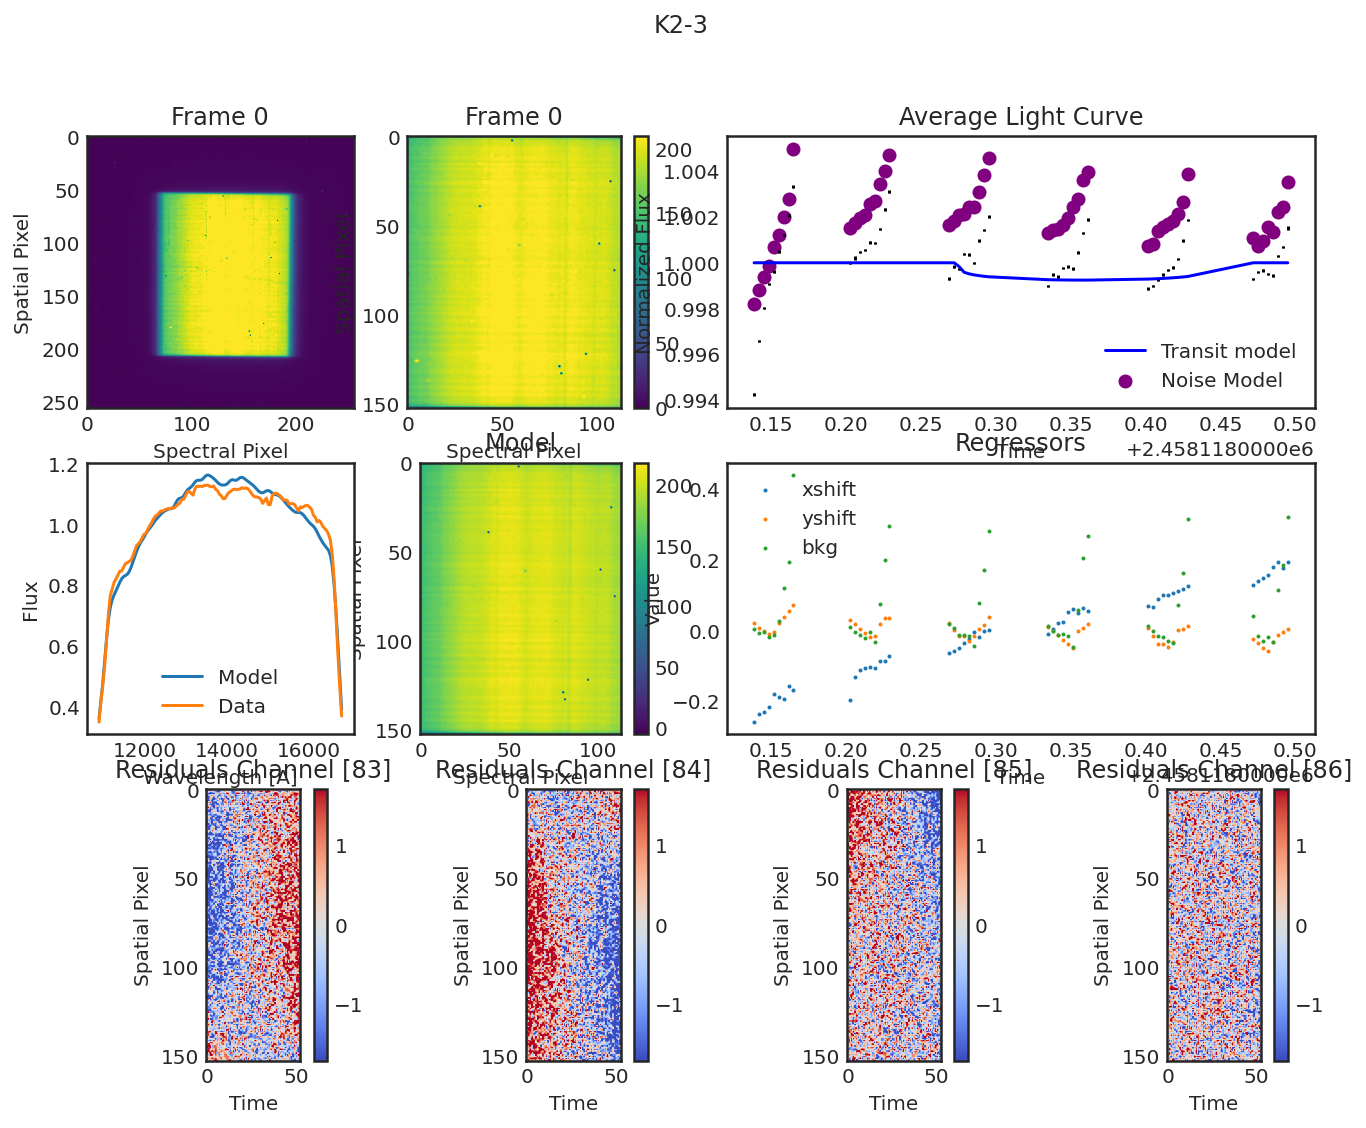

In [16]:
for visit in obs:
    visit.diagnose();
    plt.show();